In [1]:
import os

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from trimesh import Trimesh

import image
from utils import get_integer_segments, plot_region_numbers, triangulate_segments

In [2]:
with open('../data/kfs_moge_realsense/kf_1.pkl', 'rb') as file:
    data = pickle.load(file)
image_raw = data['state_dict']['image_raw'].cpu().permute(1,2,0)
sp_regions = data['state_dict']['sp_regions'].cpu().numpy()

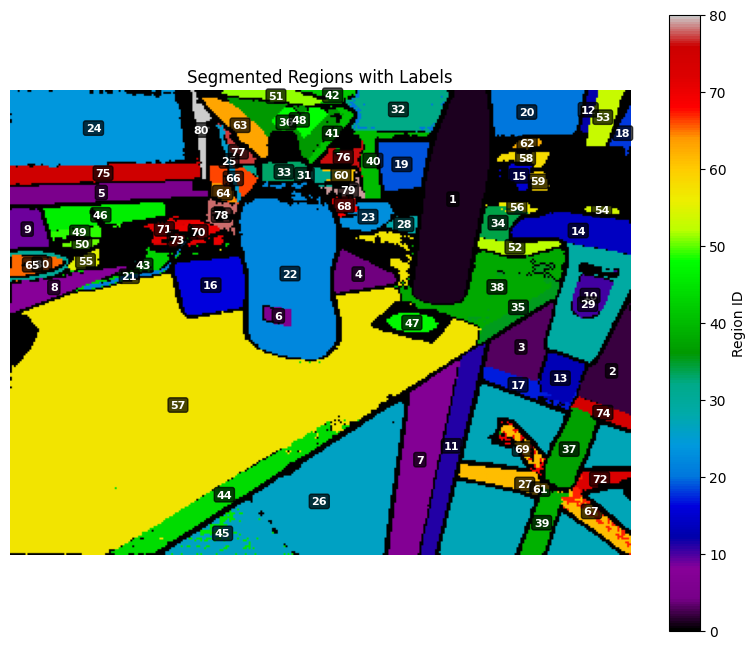

In [3]:
integer_segments = get_integer_segments(sp_regions)
plot_region_numbers(integer_segments)

In [4]:
verts = data['state_dict']['pointmap'].cpu().reshape(-1, 3)
tris = triangulate_segments(verts, integer_segments)
all_tris = [tri for trise in tris for tri in trise]
mesh = Trimesh(vertices=verts, faces=all_tris)
meshes = [Trimesh(vertices=verts, faces=individual_tris) for individual_tris in tris]

In [5]:
mesh.show()

In [6]:
mesh_A = meshes[0]
mesh_A.show()

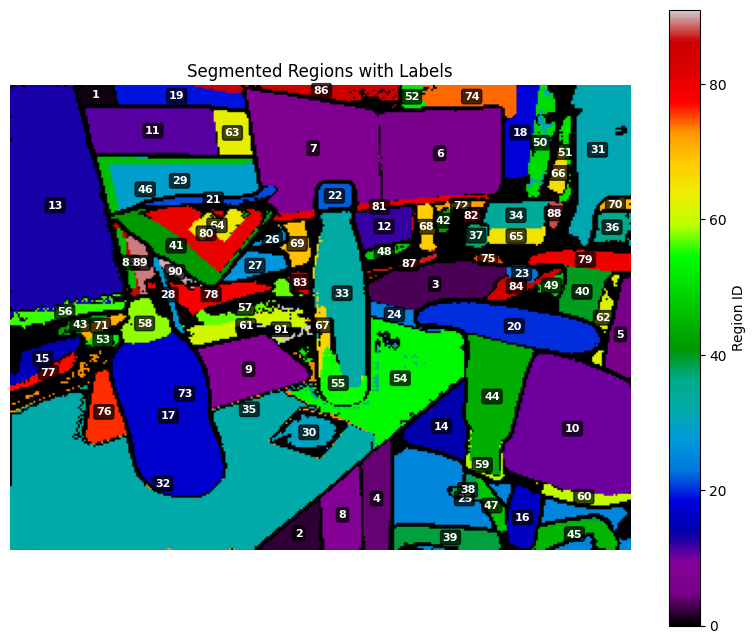

In [ ]:
with open('../data/kfs_moge_realsense/kf_51.pkl', 'rb') as file: # 51, 101
    data = pickle.load(file)
image_raw = data['state_dict']['image_raw'].cpu().permute(1,2,0)
sp_regions = data['state_dict']['sp_regions'].cpu().numpy()
integer_segments = get_integer_segments(sp_regions)
plot_region_numbers(integer_segments)

In [8]:
verts = data['state_dict']['pointmap'].cpu().reshape(-1, 3)
tris = triangulate_segments(verts, integer_segments)
all_tris = [tri for trise in tris for tri in trise]
mesh = Trimesh(vertices=verts, faces=all_tris)
meshes = [Trimesh(vertices=verts, faces=individual_tris) for individual_tris in tris]

In [9]:
mesh.show()

In [12]:
mesh_B = meshes[47]
mesh_B.show()
print(np.mean(mesh_B.edges_unique_length))

0.002834094188142316


In [25]:
import open3d as o3d

mesh_source = mesh_A
mesh_target = mesh_B

# Convert to point clouds (use vertices)
source_points = np.asarray(mesh_source.vertices)
target_points = np.asarray(mesh_target.vertices)

# Create Open3D point clouds
pcd_source = o3d.geometry.PointCloud()
pcd_target = o3d.geometry.PointCloud()
pcd_source.points = o3d.utility.Vector3dVector(source_points)
pcd_target.points = o3d.utility.Vector3dVector(target_points)

# Optionally downsample
pcd_source = pcd_source.voxel_down_sample(voxel_size=0.01)
pcd_target = pcd_target.voxel_down_sample(voxel_size=0.01)

# Run ICP
threshold = 0.005  # distance threshold
trans_init = np.eye(4)  # initial guess

reg_icp = o3d.pipelines.registration.registration_icp(
    pcd_source, pcd_target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint()
)

# Get transformation matrix
transformation = reg_icp.transformation
print("ICP Transformation:\n", transformation)

# Optionally apply transformation to source mesh
mesh_source.apply_transform(transformation)

import trimesh
mesh_target.invert()
combined = trimesh.util.concatenate([mesh_source, mesh_target])
combined.show()

ICP Transformation:
 [[ 9.99191910e-01 -1.07565392e-02  3.87275662e-02 -1.56553875e-02]
 [ 1.08892716e-02  9.99935532e-01 -3.21802756e-03  1.09544299e-03]
 [-3.86904547e-02  3.63714209e-03  9.99244625e-01  4.65576505e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [18]:
pcd_source.points = o3d.utility.Vector3dVector(source_points)
pcd_source_2 = pcd_source.voxel_down_sample(voxel_size=0.01)
o3d.visualization.draw_geometries([pcd_source_2])